<a href="https://colab.research.google.com/github/rovemin/POOM/blob/develop/dogfacenet_v10_poom_%EC%88%98%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DogFaceNet version 10: Stable version


## Imports and constants

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow.keras.backend as K
# from triplets_processing import *

resize the image

(224, 224)


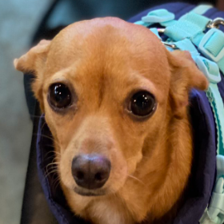

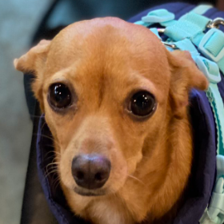

(224, 224)
(224, 224, 4)


OSError: ignored

In [ ]:
# 실패코드
import glob
from PIL import Image
from keras.utils import img_to_array

imglist = glob.glob('/content/drive/MyDrive/data/dogfacenet/1/*.jpg')

img = Image.open(imglist[0])
print(img.size)
img.show() #이미지 확인

img.resize((224, 224)).show() # Resizing 이후 다시 확인
print(img.size)

np_img = img_to_array(img)
print(np_img.shape)


for img_path in imglist:
  img = Image.open(img_path)
  img.resize((224, 224)).save(img_path) # 동일한 파일 명으로 치환된다. 


(224, 224)


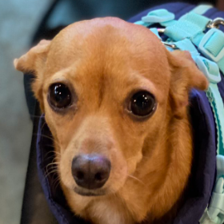

AttributeError: ignored

In [ ]:
# 실패코드
import glob
import numpy
from PIL import Image
from keras.utils import img_to_array, load_img

imglist = glob.glob('/content/drive/MyDrive/data/dogfacenet/1/*.jpg')

img = Image.open(imglist[0])
print(img.size)
img.show()

for img_path in imglist:
  img = Image.open(img_path).convert('RGB')
  # img.resize((224, 224)).save(img_path) # 동일한 파일 명으로 치환된다. 
  img = img_to_array(img)
  img = img.resize((224, 224)).show()
  #img = numpy.asarray(resize.convert('RGB'))
  #img = img.convert('RGB')
  print(img.shape())
  #img = img.reshape((224, 224, 3)).save(img_path)
  

#print(np_img.shape)



(224, 224)


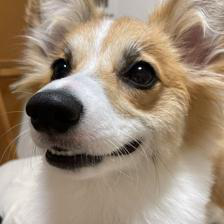

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [3]:
import glob
from PIL import Image
from keras.utils import img_to_array

imglist = glob.glob('/content/drive/MyDrive/data/dogfacenet/291/*.jpg')

img = Image.open(imglist[0])
print(img.size)
img.show() #이미지 확인

# img.resize((224, 224)).show() # Resizing 이후 다시 확인
# img.convert('RGB').save(img_path)
# print(img.size)

# np_img = img_to_array(img)
# print(np_img.shape)


for img_path in imglist:
  img = Image.open(img_path)
  # img.convert('RGB').save(img_path)
  img.resize((224, 224)).save(img_path) # 동일한 파일 명으로 치환된다. 
  # print(img.size)
  np_img = img_to_array(img)
  # np_img.reshape((224, 224, 3)).save(img_path)
  print(np_img.shape)


In [4]:
PATH = '/content/drive/MyDrive/data/dogfacenet'
PATH_SAVE = '../dogfacenet_poom/output/history/'
PATH_MODEL = '/content/drive/MyDrive/data/model'
SIZE = (224,224,3)
VALID_SPLIT = 0.1
TEST_SPLIT = 0.1

In [5]:
from PIL import Image
import cv2

## Data pre-processing
- Load image and labels
- Load .npy files create with linux and adapt them for windows
- Normalize the images
- Split into training set and testing set (open-set)

In [6]:
filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames,files)
        labels = np.append(labels, np.ones(len(files))*idx)
        idx += 1

In [7]:
print(filenames)

['/content/drive/MyDrive/data/dogfacenet/99/99.0.jpg'
 '/content/drive/MyDrive/data/dogfacenet/99/99.1.jpg'
 '/content/drive/MyDrive/data/dogfacenet/99/99.2.jpg' ...
 '/content/drive/MyDrive/data/dogfacenet/103/103.3.jpg'
 '/content/drive/MyDrive/data/dogfacenet/103/103.2.jpg'
 '/content/drive/MyDrive/data/dogfacenet/103/103.0.jpg']


In [8]:
print(labels)

[  0.   0.   0. ... 296. 296. 296.]


In [10]:
print(len(labels))
#print(filenames)
h,w,c = SIZE
images = np.empty((len(filenames),h,w,c))
for i,f in enumerate(filenames):
    images[i] = sk.io.imread(f)

1476


In [12]:
# Normalization
images /= 255.0


In [13]:
# np.unique --> 고유한 값들만 오름차순 배열로 반환 (여기서는 사용한 강아지 사진들의 폴더 개수 297개임)
nbof_classes = len(np.unique(labels))
print(nbof_classes)

297


Data splitting

In [10]:
# nbof_test = int(TEST_SPLIT*nbof_classes)

# keep_test = np.less(labels,nbof_test)
# keep_train = np.logical_not(keep_test)

# images_test = images[keep_test]
# labels_test = labels[keep_test]

# images_train = images[keep_train]
# labels_train = labels[keep_train]
# print(nbof_test)

# 이건 이 코드 내에서 학습까지 진행할 때 필요한 코드!

29


## Model definition

### Loss definition

In [14]:
alpha = 0.3
def triplet(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)

    return K.sum(tf.nn.relu(ap - an + alpha))

### Metric definition

In [15]:
def triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)
    
    return K.less(ap+alpha,an)

### Network definition

Run the following if you want to load a pre-trained model.

In [16]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/data/model/2023.03.21(load).dogfacenet.32.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})
model = tf.keras.models.load_model('/content/drive/MyDrive/data/model/2023.03.24.dogfacenet.36.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

## Training

Every n=3 epochs will be generated a new set of hard triplets. During training the learning is going to be reduce to foster convergence:

- 14*3 epochs with lr=0.001
- 4*3 epochs with lr=0.0005
- 4*3 epochs with lr=0.0003
- 4*1 epochs with lr=0.0001

The model will be saved after every points above (so 4 times in total). The convergence histories are stored in "histories" list and will be saved at the end of the training

If you want to load an existing history file, run the following two blocks.

In [17]:
# history_ = np.load('/content/drive/MyDrive/data/model/2023.03.21(load).dogfacenet.32.npy')
history_ = np.load('/content/drive/MyDrive/data/model/2023.03.24.dogfacenet.36.npy')

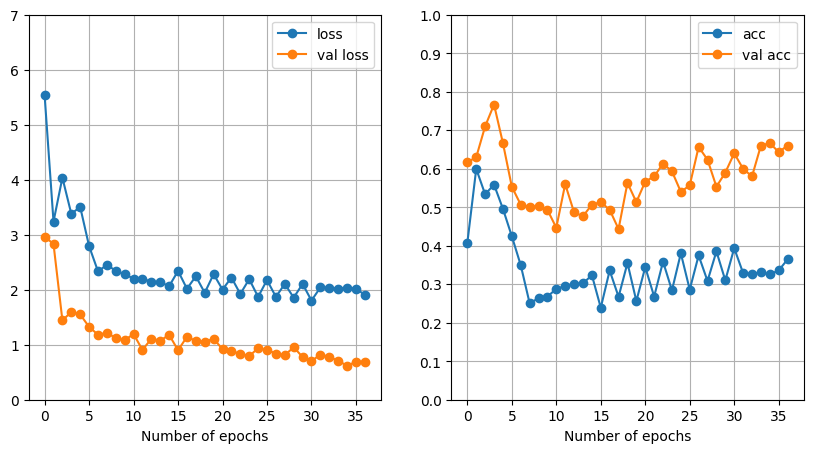

In [18]:
loss,val_loss,acc,val_acc = history_

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val loss")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,8,1))
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val acc")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.legend()

### Face clustering

In [19]:
from sklearn.cluster import KMeans

In [22]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
# predict=mod.predict(images_test)

In [24]:
# 은닉층 출력값 확인
predict=mod.predict(images)

47/47 [==============================] - 16s 332ms/step


In [18]:
# predict=model.predict(images_test) --> original code

5/5 [==============================] - 2s 245ms/step


In [25]:
predict=model.predict(images)

47/47 [==============================] - 12s 241ms/step


In [19]:
# kmeans = KMeans(n_clusters=len(np.unique(labels_test)),max_iter=2000, random_state=0,tol=0.2).fit(predict) --> original code

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [26]:
# labels_test --> labels
kmeans = KMeans(n_clusters=len(np.unique(labels)),max_iter=2000, random_state=0,tol=0.2).fit(predict)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
print(len(labels_test))

146


In [27]:
print(len(labels))

1476


In [21]:
#images_cluster = [images_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]
#labels_cluster = [labels_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))] --> original code

In [28]:
images_cluster = [images[np.equal(kmeans.labels_,i)] for i in range(len(labels))]
labels_cluster = [labels[np.equal(kmeans.labels_,i)] for i in range(len(labels))]

In [ ]:
for i in range(len(images_cluster)):
    length = len(images_cluster[i])
    if length > 0:
        print(labels_cluster[i])
        fig=plt.figure(figsize=(length*2,2))
        for j in range(length):
            plt.subplot(1,length,j+1)
            plt.imshow(images_cluster[i][j])
            plt.xticks([])
            plt.yticks([])
        fig.savefig('/content/drive/MyDrive/dogfacenet_poom/output.'+'32'+str(i)+'.png')
        plt.show()


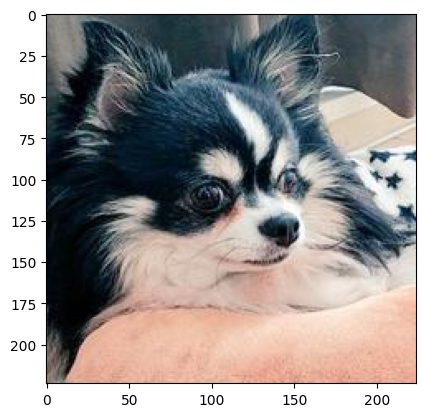

In [30]:
plt.imshow(images_cluster[10][2])